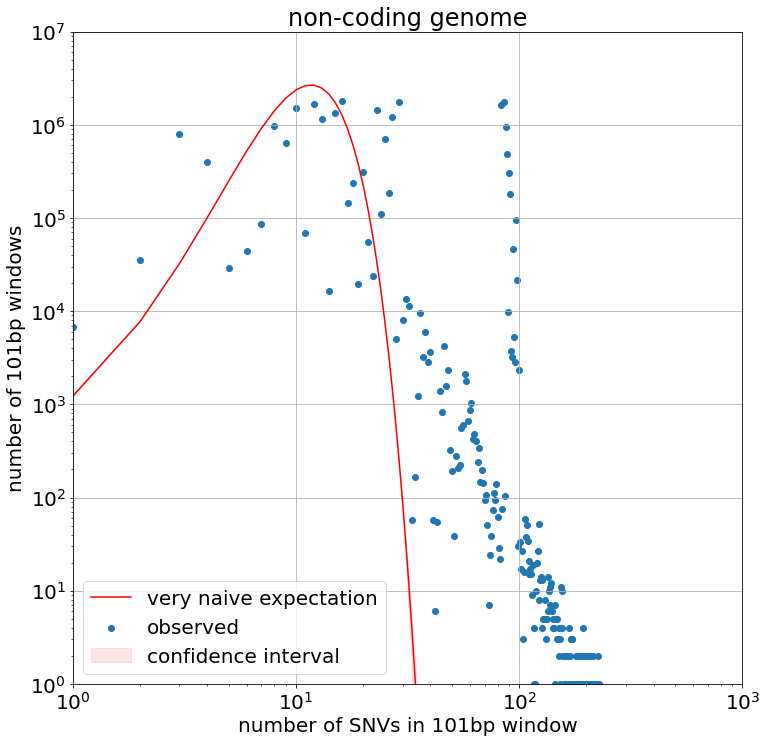

In [20]:
import json 
import matplotlib.pyplot as plt 
from scipy import stats 
import numpy as np 

model = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/dist/model-germline-grch38.json'

def get_snv_singleton_counts(): 
  with open(model, 'r') as fh:
    return json.load(fh)['singletonCounts']

def get_window_size(): 
  with open(model, 'r') as fh:
    return json.load(fh)['windowSize']

def get_observed_snvCounts_windowCounts(): 
  snv_singleton_counts = get_snv_singleton_counts()
  snv_counts, window_counts = zip(*[
    (snv_count, sum(singleton_counts)) 
    for snv_count, singleton_counts in snv_singleton_counts.items()
  ])
  return snv_counts, window_counts

def get_window_total_counts(): 
  _, window_counts_observed = get_observed_snvCounts_windowCounts()
  return sum(window_counts_observed)

def get_expected_snvCounts_windowCounts(substitution_probability=0.04): 
  # Assume 3 independent trials at each site in window, 
  # with probability of success equal to substitution_probability. 
  n, p = 3*get_window_size(), substitution_probability
  binomial = stats.binom(n, p)
  snv_counts = range(1, 3*get_window_size())
  # Each window can be categorized according to the number of SNVs it contains.
  # The probability of each category is binomial. 
  # Therefore, the number of windows in each category is multinomial, 
  # with categorical probabilities equal to the corresponding binomial probabilities.
  ps = binomial.pmf(snv_counts)
  window_counts_mean = get_window_total_counts()*ps
  window_counts_variance = get_window_total_counts()*ps*(1 - ps)
  window_counts_std = np.sqrt(window_counts_variance)
  return snv_counts, window_counts_mean, window_counts_std
  
def plot_snvCounts_windowCounts():
  snv_counts_observed, window_counts_observed = get_observed_snvCounts_windowCounts()
  snv_counts_expected, window_counts_expected_mean, window_counts_expected_std = get_expected_snvCounts_windowCounts()
  plt.rcParams.update({'font.size': 20})
  fig = plt.figure()
  fig.set_size_inches(12, 12)  
  axis = fig.add_subplot()
  axis.scatter(snv_counts_observed, window_counts_observed, label='observed')
  axis.plot(snv_counts_expected, window_counts_expected_mean, linestyle='-', marker=None, color='red', label='very naive expectation')
  axis.fill_between(
    snv_counts_expected, 
    window_counts_expected_mean - window_counts_expected_std, 
    window_counts_expected_mean + window_counts_expected_std, 
    color='red', 
    alpha=.1,
    label='confidence interval'
  )
  axis.set_xscale('log')
  axis.set_yscale('log')
  axis.set_xlabel(f'number of SNVs in {get_window_size()}bp window')
  axis.set_ylabel(f'number of {get_window_size()}bp windows')
  plt.grid(which='major')
  axis.set_xlim([1, 1e3])
  axis.set_ylim([1, 1e7])
  axis.legend()
  axis.set_title('non-coding genome')

plot_snvCounts_windowCounts()

The observed window counts are more variable than expected. This deviation between observations and expectations could be because the dependence of substitution probability on sequence (among other things) is not modeled in generating the expectation shown above (though it is of course modelled in the testing/prediction phase of constraint-tools). 

Nonetheless, there does seem to be an anomaly that occurs at SNV counts lying between 80 and 100 per window. We should manually inspect some of these windows to see whether there is an artifact that needs to be filtered out. 